## Figure timeseries $\Phi$ and $\Phi_{Tr}$

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
import matplotlib.patches as pat
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.metrics_tools as mpt
import canyon_tools.savitzky_golay as sg

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('paper')
sns.set_style('white')

def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [4]:
tracers = ['Tr01','Tr03','Tr04','Tr08','Tr09']
colours = ['#332288','#44AA99','#117733','#999933','#AA4499']
labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']


In [5]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'


state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
state = xr.open_dataset(state_file)
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [6]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    
with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    drC = nbl.variables['drC'][:]
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

<xarray.DataArray ()>
array(2029.243307513407)
Coordinates:
    T        float64 0.0
    X        float64 6.006e+04
    Y        float64 9.731e+03
    Z        float64 -2.5
<xarray.DataArray ()>
array(2226.000000340638)
Coordinates:
    T        float64 0.0
    X        float64 6.006e+04
    Y        float64 9.731e+03
    Z        float64 -2.5


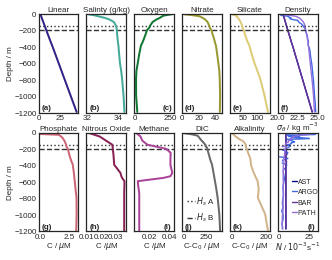

In [7]:
plt.rcParams.update({'font.size': 6})

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear','Salinty (g/kg)','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane',
         'DIC', 'Alkalinity']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

fig,((ax0,ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10,ax11)) = plt.subplots(2,6,figsize=(5,4), sharey = True)
axs = [ax0,ax1,ax2,ax3,ax4,ax6,ax7,ax8,ax9,ax10]

for ax,ii, trac, col, lab in zip(axs,range(len(tracers)),tracers , colours, labels):

    ax.axhline(-150, linestyle=':', color='0.2', label='$H_s$ A ')
    ax.axhline(-200, linestyle='--', color='0.2', label='$H_s$ B ')
    
    for pfile, Z, style in zip([ptr_fileA],[ZA],['-']):
        with Dataset(pfile, 'r') as nbl:
        
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = nbl.variables[trac][0,:,10,180]*1E-3
                ax.plot(tr_profile, Z, color=col,linestyle=style, linewidth=2)
                ax.set_xlabel(r'C /$\mu$M', labelpad=0,fontsize=8)
            
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = (density*profile/1000)
                
                if (trac == 'Tr09' or trac == 'Tr10'):
                    ax.plot(tr_profile-tr_profile[0], Z, color=col,linestyle=style, linewidth=2)
                    ax.set_xlabel(r'C-C$_0$ / $\mu$M', labelpad=0,fontsize=8)
                    print(tr_profile[0])
                else:
                    ax.plot(tr_profile, Z, color=col,linestyle=style, linewidth=2)
                    ax.set_xlabel(r'C / $\mu$M', labelpad=0,fontsize=8)
            else:
                ax.set_xlabel(r'C / $\mu$M', labelpad=0,fontsize=8)
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax.plot(tr_profile, Z, color=col,linestyle=style, linewidth=2)
                
        ax.set_title(lab, fontsize=8,pad=2)
        ax.set_ylim(-1200,0)
        ax.tick_params(axis='x', pad=2)
  
for ax, ax_lab in zip([ax0,ax1,ax3,ax4], ['(a)','(b)','(d)','(e)']):
    ax.set_xlabel('')
    ax.text(0.07,0.03,ax_lab,fontsize=8, fontweight='bold',  transform=ax.transAxes )

for ax, ax_lab in zip([ax6,ax7,ax9,ax10], ['(g)','(h)','(j)','(k)']):
    ax.text(0.07,0.03,ax_lab,fontsize=8, fontweight='bold',  transform=ax.transAxes )

ax5.text(0.07,0.03,'(f)',fontsize=8, fontweight='bold',  transform=ax5.transAxes )
ax11.text(0.75,0.03,'(l)',fontsize=8, fontweight='bold',  transform=ax11.transAxes )
ax8.text(0.75,0.03,'(i)',fontsize=8, fontweight='bold',  transform=ax8.transAxes )
ax2.text(0.71,0.03,'(c)',fontsize=8, fontweight='bold',  transform=ax2.transAxes )
ax2.set_xlabel('')
    
ax0.set_ylabel('Depth / m', labelpad=0,fontsize=8)        
ax6.set_ylabel('Depth / m', labelpad=0,fontsize=8)        
ax9.legend(loc=0, handlelength=1, handletextpad=0.1, fontsize=8)
ax0.tick_params(axis='y', pad=2)
ax6.tick_params(axis='y', pad=2)

# density
colors_rho = ['darkblue', 'royalblue', 'rebeccapurple','mediumpurple']
labels_rho = ['AST', 'ARGO', 'BAR', 'PATH']

state_files = ['/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc',
              '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc',
              '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc',
              '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/stateGlob.nc']

for st, col, lab in zip(state_files,colors_rho,labels_rho):
    ss = xr.open_dataset(st)
    density = call_rho(0,ss,slice(0,104),180,20)
    N = np.sqrt(-(9.81/RhoRef)*((density.data[2:]-density.data[:-2])/((Z[2:]-Z[:-2]))))
    
    ax5.plot(density-1000,Z, color=col, label=lab) 
    ax11.plot(N*1000,Z[1:-1], color=col, label=lab) 

ax5.axhline(-150, linestyle=':', color='0.2')
ax5.axhline(-200, linestyle='--', color='0.2')
ax11.axhline(-150, linestyle=':', color='0.2')
ax11.axhline(-200, linestyle='--', color='0.2')
    
ax11.legend(bbox_to_anchor=(0.2,0.6), fontsize=7,handlelength=0.7, handletextpad=0.1)
ax5.set_title('Density', fontsize=8,pad=2)
ax5.set_xlabel(r'$\sigma_{\theta}$ / kg m$^{-3}$', labelpad=-1,fontsize=8)
ax5.tick_params(axis='x', pad=2)
ax11.tick_params(axis='x', pad=2)
ax11.set_xlabel('$N$ / $10^{-3}$s$^{-1}$', labelpad=0,fontsize=8)


plt.savefig('tracer_profiles.eps',format='eps', bbox_inches='tight')

In [8]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

tracers_C = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels_C = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))
sb_dTdz_A = np.empty(len(labels))
sb_dTdz_B = np.empty(len(labels))
sb_dTdzmean_A = np.empty(len(labels))
sb_dTdzmean_B = np.empty(len(labels))
sb_d2Tdz2_A = np.empty(len(labels))
sb_d2Tdz2_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers_C)),tracers_C):
    for pfile,sb_array,dT_array,dT_array_mean,d2T_array,sb_ind in zip([ptr_fileB, ptr_fileA],[sb_conc_A, sb_conc_B],
                                                                      [sb_dTdz_A, sb_dTdz_B],
                                                                      [sb_dTdzmean_A, sb_dTdzmean_B],
                                                                      [sb_d2Tdz2_A, sb_d2Tdz2_B],
                                                                      [sb_Ast, sb_Bar]):
        with Dataset(pfile, 'r') as nbl:
            
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180]
                dTrdz = (tr_profile[2:]-tr_profile[:-2])/(drC[3:]+drC[1:-2])  
                d2Trdz2 = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drC[3:]*drC[1:-2])  
               
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = (density.data*nbl.variables[trac][0,:,10,180])/1000
                dTrdz = (tr_profile[2:]-tr_profile[:-2])/(drC[3:]+drC[1:-2])   
                d2Trdz2 = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drC[3:]*drC[1:-2])  
                
            else:
                tr_profile = nbl.variables[trac][0,:,10,180]
                dTrdz = (tr_profile[2:]-tr_profile[:-2])/(drC[3:]+drC[1:-2])  
                d2Trdz2 = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drC[3:]*drC[1:-2])  
                
            sb_array[ii] = tr_profile[sb_ind]
            dT_array[ii] = np.mean(dTrdz[sb_ind-1:sb_ind+1])
            dT_array_mean[ii] = np.mean(dTrdz[sb_ind-8:sb_ind+8])
            d2T_array[ii] = np.mean(d2Trdz2[sb_ind-2:sb_ind+2])
            

In [9]:
labels_exp = ['Astoria', 'Barkley']
labels_tra = ['Lin','Sal','Oxy','Nit','Sil','Pho','NiO','Met','DIC','Alk']

print ("\t".join(['Tracer &', 
                  'C_s/ umol/L &',
                  'dCdz umol/L m',
                  'd^2Cz^2 umol/L m^2'
                 ]))

for tr_lab, CsA, dTA, d2TA, CsB, dTB, d2TB in zip(labels_tra, sb_conc_A, sb_dTdz_A, 
                                                  sb_d2Tdz2_A, sb_conc_B, sb_dTdz_B, sb_d2Tdz2_B ):
    
   
    print ("\t".join(['Astoria %s &' %(tr_lab), 
                      '%1.2e &' %(CsA),
                      '%1.2e &' %(dTA),
                      '%1.2e skl' %(d2TA),
                     ]))
    print ("\t".join(['Barkley %s &' %(tr_lab), 
                      '%1.2e &' %(CsB),
                      '%1.2e &' %(dTB),
                      '%1.2e skl' %(d2TB),
                     ]))
   

Tracer &	C_s/ umol/L &	dCdz umol/L m	d^2Cz^2 umol/L m^2
Astoria Lin &	7.22e+00 &	3.60e-02 &	0.00e+00 skl
Barkley Lin &	9.02e+00 &	3.60e-02 &	9.54e-09 skl
Astoria Sal &	3.39e+01 &	1.48e-03 &	-9.62e-05 skl
Barkley Sal &	3.39e+01 &	5.48e-04 &	-1.54e-05 skl
Astoria Oxy &	1.06e+02 &	-2.41e-01 &	1.02e-02 skl
Barkley Oxy &	8.66e+01 &	-2.81e-01 &	1.66e-02 skl
Astoria Nit &	3.26e+01 &	3.44e-02 &	-6.47e-04 skl
Barkley Nit &	3.49e+01 &	3.69e-02 &	-1.31e-03 skl
Astoria Sil &	4.76e+01 &	6.60e-02 &	-3.75e-03 skl
Barkley Sil &	5.25e+01 &	1.00e-01 &	-2.13e-03 skl
Astoria Pho &	2.25e+00 &	1.76e-03 &	-9.45e-05 skl
Barkley Pho &	2.39e+00 &	2.36e-03 &	-1.14e-04 skl
Astoria NiO &	2.77e-02 &	2.68e-05 &	-4.03e-06 skl
Barkley NiO &	2.80e-02 &	6.17e-06 &	-3.54e-08 skl
Astoria Met &	1.75e-02 &	3.07e-04 &	1.37e-05 skl
Barkley Met &	3.63e-02 &	1.62e-04 &	-1.42e-05 skl
Astoria DIC &	2.27e+03 &	6.53e-01 &	-4.28e-02 skl
Barkley DIC &	2.29e+03 &	2.48e-01 &	1.41e-06 skl
Astoria Alk &	2.31e+03 &	1.44e-01 &	-1.24e-02 sk

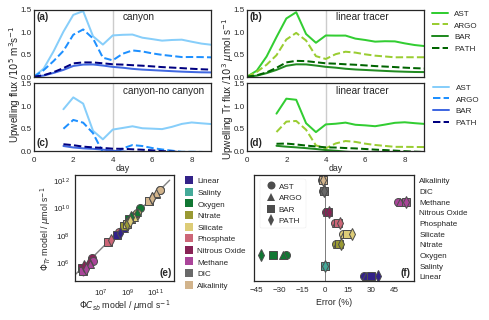

In [10]:
sns.set_style('white')
sns.set_context('paper')
plt.rcParams.update({'font.size': 11})
fig=plt.figure(figsize=(7,5))

gs = gspec.GridSpec(2, 1, hspace=0.2, wspace=0.2, height_ratios=[2,1.5])
gs0 = gspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0],hspace=0.1, wspace=0.2)
gs1 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],hspace=0.1, wspace=0.15)

ax0 = plt.subplot(gs0[0,0],xticks=[])
ax1 = plt.subplot(gs0[0,1],xticks=[])
ax2 = plt.subplot(gs0[1,0])
ax3 = plt.subplot(gs0[1,1])
ax4 = plt.subplot(gs1[0])
ax5 = plt.subplot(gs1[1])

colors_water = ['lightskyblue','dodgerblue', 'royalblue','navy']
colors_tracer = ['limegreen','yellowgreen','forestgreen','darkgreen']
    
for ax in [ax0,ax1,ax2,ax3]:
    ax.set_xlim(0,9)
    ax.axvline(4,color='0.8')

#------- Plot linear tracer time series of HCW and Tr Mass--------------------------------------------------------
f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_01_Ast03.csv')
df_Ast = pd.read_csv(f_Ast)
HCW_Ast = df_Ast['Phi']
TrMass_Ast = df_Ast['phiTr01']

f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_02_Ast03_No_Cny.csv')
df_AstNoC = pd.read_csv(f_AstNoC)
HCW_AstNoC = df_AstNoC['Phi']
TrMass_AstNoC = df_AstNoC['phiTr01']

f_Ast3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_03_Ast03_Argo.csv')
df_Ast3 = pd.read_csv(f_Ast3)
HCW_Ast3 = df_Ast3['Phi']
TrMass_Ast3 = df_Ast3['phiTr01']

f_Ast3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_04_Ast03_No_Cny_Argo.csv')
df_Ast3NoC = pd.read_csv(f_Ast3NoC)
HCW_Ast3NoC = df_Ast3NoC['Phi']
TrMass_Ast3NoC = df_Ast3NoC['phiTr01']

f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_01_Bar03.csv')
df_Bar = pd.read_csv(f_Bar)
HCW_Bar = df_Bar['Phi']
TrMass_Bar = df_Bar['phiTr01']

f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_02_Bar03_No_Cny.csv')
df_BarNoC = pd.read_csv(f_BarNoC)
HCW_BarNoC = df_BarNoC['Phi']
TrMass_BarNoC = df_BarNoC['phiTr01']

f_Bar3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_03_Bar03_Path.csv')
df_Bar3 = pd.read_csv(f_Bar3)
HCW_Bar3 = df_Bar3['Phi']
TrMass_Bar3 = df_Bar3['phiTr01']

f_Bar3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_04_Bar03_No_Cny_Path.csv')
df_Bar3NoC = pd.read_csv(f_Bar3NoC)
HCW_Bar3NoC = df_Bar3NoC['Phi']
TrMass_Bar3NoC = df_Bar3NoC['phiTr01']


ax0.plot(np.arange(19)/2, HCW_Ast/1E5, color=colors_water[0], linewidth=2, label='AST')
ax0.plot(np.arange(19)/2, HCW_Ast3/1E5,'--', color=colors_water[1],linewidth=2, label='ARGO')
ax0.plot(np.arange(19)/2, HCW_Bar/1E5, color=colors_water[2],  linewidth=2, label='BAR')
ax0.plot(np.arange(19)/2, HCW_Bar3/1E5,'--', color=colors_water[3],linewidth=2, label='PATH')

ax1.plot(np.arange(19)/2, TrMass_Ast*1E-3/1E3, color=colors_tracer[0], label='AST', linewidth=2) #*1E-3 to convert 1L to m^3
ax1.plot(np.arange(19)/2, TrMass_Ast3*1E-3/1E3,'--', color=colors_tracer[1], label='ARGO', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar*1E-3/1E3, color=colors_tracer[2], label='BAR', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar3*1E-3/1E3,'--', color=colors_tracer[3],linewidth=2,label='PATH')

ax2.plot(np.arange(19)/2, (HCW_Ast-HCW_AstNoC)/1E5, color=colors_water[0], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Ast3-HCW_Ast3NoC)/1E5,'--', color=colors_water[1], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar-HCW_BarNoC)/1E5, color=colors_water[2], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar3-HCW_Bar3NoC)/1E5,'--', color=colors_water[3],linewidth=2,)

ax3.plot(np.arange(19)/2, (TrMass_Ast-TrMass_AstNoC)*1E-3/1E3, color=colors_tracer[0],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Ast3-TrMass_Ast3NoC)*1E-3/1E3,'--', color=colors_tracer[1],  linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar-TrMass_BarNoC)*1E-3/1E3, color=colors_tracer[2],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar3-TrMass_Bar3NoC)*1E-3/1E3,'--', color=colors_tracer[3],linewidth=2,)

   
ax0.text(-0.15,0.6,'Upwelling flux /$10^{5}$ m$^3$s$^{-1}$',fontsize=10,  transform=ax0.transAxes, rotation=90)
ax1.text(-0.15,0.7,'Upwelling Tr flux /$10^{3}$ $\mu$mol s$^{-1}$',fontsize=10,  transform=ax1.transAxes, rotation=90)
ax0.text(0.5,0.85,'canyon',fontsize=10,  transform=ax0.transAxes)
ax2.text(0.5,0.85,'canyon-no canyon',fontsize=10,  transform=ax2.transAxes)
ax1.text(0.5,0.85,'linear tracer',fontsize=10,  transform=ax1.transAxes)
ax3.text(0.5,0.85,'linear tracer',fontsize=10,  transform=ax3.transAxes)

ax2.set_xlabel('day', labelpad=0)
ax3.set_xlabel('day', labelpad=0)
ax0.set_ylim(0,1.5)
ax2.set_ylim(0,1.5)
ax1.set_ylim(0,1.5)
ax3.set_ylim(0,1.5)
ax1.legend(bbox_to_anchor=(1,1.1))
ax0.legend(bbox_to_anchor=(2.55,0))
ax0.tick_params(axis='y', which='major', pad=2)
ax1.tick_params(axis='y', which='major', pad=2)
ax2.tick_params(axis='y', which='major', pad=2)
ax3.tick_params(axis='y', which='major', pad=2)
#------- Plot Phi_Tr vs upwelling estimate*Cs --------------------------------------------------------

tracers = ['phiTr01', 'phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
           'phiTr07','phiTr08','phiTr09','phiTr10']
labels = ['Linear','Salinty','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide',
          'Methane','DIC', 'Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 
           'dimgray', 'tan']

markers=['o','^','s','d']
runs = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

ax5.axvline(0, linewidth=1, color='0.5')
for exp, run, mark in zip(exps, runs, markers):
    ii = 0
    for key, lab, col, Csb in zip(tracers, labels, colours, sb_conc_A):
        file = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run))
        df = pd.read_csv(file)
        Phi = 1000*df['Phi'][:] # *1000 to go from m^3/s to L/s

        if (key == 'phiTr07' or key == 'phiTr08'):
            PhiTr = df[key][:] # nMm^3 to muMm^3 and muMm^3 to mumol

        else:
            PhiTr = 1E3*df[key][:]

        Phi2 = np.mean(np.array(Phi[8:]))
        Phi_std = np.std(np.array(Phi[8:]))
        
        PhiTr2 = np.mean(np.array(PhiTr[8:]))
        PhiTr_std = np.std(np.array(PhiTr[8:]))
        
        error = 100*(PhiTr2-(Phi2*Csb))/PhiTr2
        ax4.errorbar(PhiTr2, Phi2*Csb, yerr=PhiTr_std, xerr=Csb*Phi_std,
                     marker=mark, markersize=8,markerfacecolor=col, 
                     markeredgecolor='0.3', markeredgewidth=1,ecolor=col )
        ax5.errorbar(error,ii,  marker=mark, markersize=8,markerfacecolor=col, 
                     markeredgecolor='0.3', markeredgewidth=1, ecolor=col)
        ii=ii+1
ax4.plot(np.linspace(0,1E12,50),np.linspace(0,1E12,50),'-', color='0.5')    
    
#ax4.set_ylim(1E5,1E12)
#ax4.set_xlim(1E5,1E12)
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_aspect(1)
ax4.set_ylabel(r'$\Phi_{Tr}$ model / $\mu$mol s$^{-1}$', labelpad=0)
ax4.set_xlabel(r'$\Phi C_{sb}$ model / $\mu$mol s$^{-1}$', labelpad=0)

legend_runs =     [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='0.3', mec='0.3',markersize=8),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='0.3', mec='0.3',markersize=8),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='0.3', mec='0.3',markersize=8),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='0.3', mec='0.3',markersize=8),  
                  ]
legend_elements=[]
for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=8),)

ax4.legend(handles=legend_elements, bbox_to_anchor=(1,1.05), handletextpad=0)
ax5.legend(handles=legend_runs, bbox_to_anchor=(0.35,1), handletextpad=0, ncol=1,
           columnspacing=-0.05,frameon=True  )

ax5.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax5.set_yticklabels(labels)
ax5.set_xlabel('Error (%)', labelpad=4)
ax5.yaxis.tick_right()
ax5.set_xticks([-45,-30,-15,0,15,30,45])
ax5.set_aspect(7)

ax0.text(0.015,0.85,'(a)',fontsize=10, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.015,0.85,'(b)',fontsize=10, fontweight='bold',  transform=ax1.transAxes)
ax2.text(0.015,0.07,'(c)',fontsize=10, fontweight='bold',  transform=ax2.transAxes)
ax3.text(0.015,0.07,'(d)',fontsize=10, fontweight='bold',  transform=ax3.transAxes)
ax4.text(0.85,0.05,'(e)',fontsize=10, fontweight='bold',  transform=ax4.transAxes)
ax5.text(0.92,0.05,'(f)',fontsize=10, fontweight='bold',  transform=ax5.transAxes)


plt.savefig('upwelled_water.eps',format='eps', bbox_inches='tight')

phiTr01 25.6596643976
phiTr02 0.122717466043
phiTr03 -25.8640201486
phiTr04 7.4393430774
phiTr05 11.7278974231
phiTr06 6.64257390398
phiTr07 0.736598945873
phiTr08 47.5486908211
phiTr09 -1.07557676623
phiTr10 -1.73283873419
phiTr01 26.4812619691
phiTr02 0.139739983904
phiTr03 -27.7090429259
phiTr04 7.81865925392
phiTr05 12.2571365502
phiTr06 7.0037723959
phiTr07 1.25435774197
phiTr08 49.0715669357
phiTr09 -0.992902902747
phiTr10 -1.7055685484
phiTr01 29.9551531462
phiTr02 0.173962866791
phiTr03 -34.255654918
phiTr04 9.16949314705
phiTr05 14.3310261504
phiTr06 8.26615414873
phiTr07 1.89867746323
phiTr08 52.9379822943
phiTr09 -0.767603180947
phiTr10 -1.62190805652
phiTr01 34.6285691574
phiTr02 0.206004575039
phiTr03 -42.0229443384
phiTr04 10.5862547806
phiTr05 17.4575428648
phiTr06 9.88277947556
phiTr07 2.25510885622
phiTr08 53.1003773027
phiTr09 -0.540750194699
phiTr10 -1.50155915008


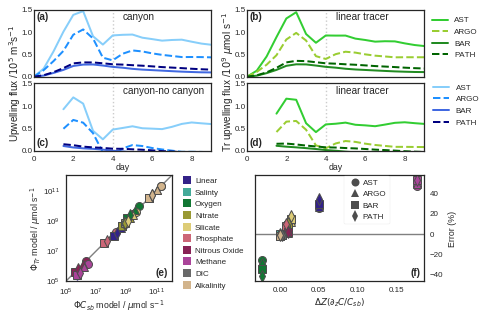

In [11]:
sns.set_style('white')
sns.set_context('paper')
plt.rcParams.update({'font.size': 11})
fig=plt.figure(figsize=(7,5))

gs = gspec.GridSpec(2, 1, hspace=0.2, wspace=0.2, height_ratios=[2,1.5])
gs0 = gspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0],hspace=0.1, wspace=0.2)
gs1 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],hspace=0.1, wspace=0.3, width_ratios=[1,1])

ax0 = plt.subplot(gs0[0,0],xticks=[])
ax1 = plt.subplot(gs0[0,1],xticks=[])
ax2 = plt.subplot(gs0[1,0])
ax3 = plt.subplot(gs0[1,1])
ax4 = plt.subplot(gs1[0])
ax5 = plt.subplot(gs1[1])

colors_water = ['lightskyblue','dodgerblue', 'royalblue','navy']
colors_tracer = ['limegreen','yellowgreen','forestgreen','darkgreen']
    
for ax in [ax0,ax1,ax2,ax3]:
    ax.set_xlim(0,9)
    ax.axvline(4,color='0.8', linestyle=':')

#------- Plot linear tracer time series of HCW and Tr Mass--------------------------------------------------------
f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_01_Ast03.csv')
df_Ast = pd.read_csv(f_Ast)
HCW_Ast = df_Ast['Phi']
TrMass_Ast = df_Ast['phiTr01']

f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_02_Ast03_No_Cny.csv')
df_AstNoC = pd.read_csv(f_AstNoC)
HCW_AstNoC = df_AstNoC['Phi']
TrMass_AstNoC = df_AstNoC['phiTr01']

f_Ast3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_03_Ast03_Argo.csv')
df_Ast3 = pd.read_csv(f_Ast3)
HCW_Ast3 = df_Ast3['Phi']
TrMass_Ast3 = df_Ast3['phiTr01']

f_Ast3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_04_Ast03_No_Cny_Argo.csv')
df_Ast3NoC = pd.read_csv(f_Ast3NoC)
HCW_Ast3NoC = df_Ast3NoC['Phi']
TrMass_Ast3NoC = df_Ast3NoC['phiTr01']

f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_01_Bar03.csv')
df_Bar = pd.read_csv(f_Bar)
HCW_Bar = df_Bar['Phi']
TrMass_Bar = df_Bar['phiTr01']

f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_02_Bar03_No_Cny.csv')
df_BarNoC = pd.read_csv(f_BarNoC)
HCW_BarNoC = df_BarNoC['Phi']
TrMass_BarNoC = df_BarNoC['phiTr01']

f_Bar3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_03_Bar03_Path.csv')
df_Bar3 = pd.read_csv(f_Bar3)
HCW_Bar3 = df_Bar3['Phi']
TrMass_Bar3 = df_Bar3['phiTr01']

f_Bar3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_04_Bar03_No_Cny_Path.csv')
df_Bar3NoC = pd.read_csv(f_Bar3NoC)
HCW_Bar3NoC = df_Bar3NoC['Phi']
TrMass_Bar3NoC = df_Bar3NoC['phiTr01']


ax0.plot(np.arange(19)/2, HCW_Ast/1E5, color=colors_water[0], linewidth=2, label='AST')
ax0.plot(np.arange(19)/2, HCW_Ast3/1E5,'--', color=colors_water[1],linewidth=2, label='ARGO')
ax0.plot(np.arange(19)/2, HCW_Bar/1E5, color=colors_water[2],  linewidth=2, label='BAR')
ax0.plot(np.arange(19)/2, HCW_Bar3/1E5,'--', color=colors_water[3],linewidth=2, label='PATH')

ax1.plot(np.arange(19)/2, TrMass_Ast/1E-3/1E9, color=colors_tracer[0], label='AST', linewidth=2) #*1E-3 to convert 1L to m^3
ax1.plot(np.arange(19)/2, TrMass_Ast3/1E-3/1E9,'--', color=colors_tracer[1], label='ARGO', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar/1E-3/1E9, color=colors_tracer[2], label='BAR', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar3/1E-3/1E9,'--', color=colors_tracer[3],linewidth=2,label='PATH')

ax2.plot(np.arange(19)/2, (HCW_Ast-HCW_AstNoC)/1E5, color=colors_water[0], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Ast3-HCW_Ast3NoC)/1E5,'--', color=colors_water[1], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar-HCW_BarNoC)/1E5, color=colors_water[2], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar3-HCW_Bar3NoC)/1E5,'--', color=colors_water[3],linewidth=2,)

ax3.plot(np.arange(19)/2, (TrMass_Ast-TrMass_AstNoC)/1E-3/1E9, color=colors_tracer[0],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Ast3-TrMass_Ast3NoC)/1E-3/1E9,'--', color=colors_tracer[1],  linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar-TrMass_BarNoC)/1E-3/1E9, color=colors_tracer[2],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar3-TrMass_Bar3NoC)/1E-3/1E9,'--', color=colors_tracer[3],linewidth=2,)

   
ax0.text(-0.15,0.6,'Upwelling flux /$10^{5}$ m$^3$s$^{-1}$',fontsize=10,  transform=ax0.transAxes, rotation=90)
ax1.text(-0.15,0.8,'Tr upwelling flux /$10^{9}$ $\mu$mol s$^{-1}$',fontsize=10,  transform=ax1.transAxes, rotation=90)
ax0.text(0.5,0.85,'canyon',fontsize=10,  transform=ax0.transAxes)
ax2.text(0.5,0.85,'canyon-no canyon',fontsize=10,  transform=ax2.transAxes)
ax1.text(0.5,0.85,'linear tracer',fontsize=10,  transform=ax1.transAxes)
ax3.text(0.5,0.85,'linear tracer',fontsize=10,  transform=ax3.transAxes)

ax2.set_xlabel('day', labelpad=0)
ax3.set_xlabel('day', labelpad=0)
ax0.set_ylim(0,1.5)
ax2.set_ylim(0,1.5)
ax1.set_ylim(0,1.5)
ax3.set_ylim(0,1.5)

ax0.tick_params(axis='y', pad=1)
ax1.tick_params(axis='y', pad=1)
ax2.tick_params(axis='y', pad=1)
ax3.tick_params(axis='y', pad=1)

ax1.legend(bbox_to_anchor=(1,1))
ax0.legend(bbox_to_anchor=(2.55,0))

#------- Plot Phi_Tr vs upwelling estimate*Cs --------------------------------------------------------

tracers = ['phiTr01', 'phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
           'phiTr07','phiTr08','phiTr09','phiTr10']
labels = ['Linear','Salinty','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane',
         'DIC', 'Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
markers=['o','^','s','d']
runs = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

for exp, run, mark in zip(exps,runs,markers):
    ii = 0
    for key, lab, col, Csb, dT, dTmean, d2T in zip(tracers, labels, colours, sb_conc_A, sb_dTdz_A, sb_dTdzmean_A,
                                                  sb_d2Tdz2_A):
        file = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run))
        df = pd.read_csv(file)
        Phi = 1000*df['Phi'][:] # *1000 to go from m^3/s to L/s

        if (key == 'phiTr07' or key == 'phiTr08'):
            PhiTr = df[key][:] # nMm^3 to muMm^3 and muMm^3 to mumol

        else:
            PhiTr = 1E3*df[key][:]

        Phi2 = np.mean(np.array(Phi[8:]))
        Phi_std = np.std(np.array(Phi[8:]))
        
        PhiTr2 = np.mean(np.array(PhiTr[8:]))
        PhiTr_std = np.std(np.array(PhiTr[8:]))
        
        error = 100*(PhiTr2-(Phi2*Csb))/PhiTr2
        ax4.errorbar(PhiTr2, Phi2*Csb, yerr=PhiTr_std,xerr=Csb*Phi_std, marker=mark, markersize=8,markerfacecolor=col, 
                     markeredgecolor='0.3', markeredgewidth=1)
        tau_v = dT*10/Csb #10 m scale gradient  #100*d2T/dT
        ax5.errorbar(tau_v,error, marker=mark, markersize=8,markerfacecolor=col, 
                     markeredgecolor='0.3', markeredgewidth=1)
        ii=ii+1
        print(key,error)
ax4.plot(np.linspace(0,1E12,50),np.linspace(0,1E12,50),'-', color='0.5')    
    
ax4.set_ylim(1E5,1E12)
ax4.set_xlim(1E5,1E12)
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_aspect(1)
ax4.set_ylabel(r'$\Phi_{Tr}$ model / $\mu$mol s$^{-1}$', labelpad=0)
ax4.set_xlabel(r'$\Phi C_{sb}$ model / $\mu$mol s$^{-1}$', labelpad=0)

legend_runs =     [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='0.3', mec='0.3',markersize=8),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='0.3', mec='0.3',markersize=8),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='0.3', mec='0.3',markersize=8),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='0.3', mec='0.3',markersize=8),  
                  ]
legend_elements=[]
for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=8),)

ax4.legend(handles=legend_elements, bbox_to_anchor=(1,1.05), handletextpad=0)
ax5.legend(handles=legend_runs, bbox_to_anchor=(0.5,0.5), handletextpad=0, ncol=1,
           columnspacing=-0.05,frameon=True  )

ax5.yaxis.set_label_position("right")
ax5.set_xlabel(r'$\Delta Z(\partial_zC/C_{sb})$', labelpad=2)
ax5.set_ylabel('Error (%)', labelpad=4)
ax5.yaxis.tick_right()
ax5.axhline(0,color='0.5')
#ax5.set_yticks([-5,0,5,10,15,20])
#ax5.set_aspect(0.019)

ax0.text(0.015,0.85,'(a)',fontsize=10, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.015,0.85,'(b)',fontsize=10, fontweight='bold',  transform=ax1.transAxes)
ax2.text(0.015,0.07,'(c)',fontsize=10, fontweight='bold',  transform=ax2.transAxes)
ax3.text(0.015,0.07,'(d)',fontsize=10, fontweight='bold',  transform=ax3.transAxes)
ax4.text(0.85,0.05,'(e)',fontsize=10, fontweight='bold',  transform=ax4.transAxes)
ax5.text(0.92,0.05,'(f)',fontsize=10, fontweight='bold',  transform=ax5.transAxes)

plt.savefig('upwelled_water_v2.eps',format='eps', bbox_inches='tight')


### Table Tracer on Shelf

In [12]:
labels_exp = ['Astoria', 'Ast. ARGO', 'Barkley', 'Bar. Path.']
labels_tra = ['Lin','Sal','Oxy','Nit','Sil','Pho','NiO','Met','DIC','Alk']
tracers_phi = ['phiTr01', 'phiTr02','phiTr03','phiTr04','phiTr05',
           'phiTr06','phiTr07','phiTr08','phiTr09','phiTr10']
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']

labels = ['Linear','Salinty','Oxygen','Nitrate','Silicate','Phosphate',
          'Nitrous Oxide','Methane','DIC', 'Alkalinity']
runs = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']


print ("\t".join(['Run and Tracer &', 
                  '$\Phi_{Tr}$/10^{9} umol/s &',
                  #'$M_can$/10^{12} umol',
                  #'$M_{can}-M_{nc}/M_{can}$ day 9'
                  '$\mathcal{M}-$\mathcal{M}_{nc}$/10^{12} umol &',
                  '$\% &',
                 ]))

exp_files = ['saved_calcs/pool_AST.nc',
             'saved_calcs/pool_ARGO.nc',
             'saved_calcs/pool_BAR.nc',
             'saved_calcs/pool_PATH.nc']

exp_files_BAC = ['saved_calcs/BAC_AST.nc',
                 'saved_calcs/BAC_ARGO.nc',
                 'saved_calcs/BAC_BAR.nc',
                 'saved_calcs/BAC_PATH.nc']

  
for key,keyPhi, tr_lab in zip(tracers,tracers_phi,labels_tra):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_01_Ast03.csv')
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_02_Ast03_No_Cny.csv')
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_03_Ast03_Argo.csv')
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/phi_phiTr_transAlg_04_Ast03_No_Cny_Argo.csv')
    
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_01_Bar03.csv')
    f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_02_Bar03_No_Cny.csv')
    f_Path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_03_Bar03_Path.csv')
    f_PathNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/phi_phiTr_transAlg_04_Bar03_No_Cny_Path.csv')
    
    f2_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f2_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f2_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f2_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    
    f2_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f2_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f2_Path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    f2_PathNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
   
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    df_Bar = pd.read_csv(f_Bar)
    df_Path = pd.read_csv(f_Path)
    df_BarNoC = pd.read_csv(f_BarNoC)
    df_PathNoC = pd.read_csv(f_PathNoC)
    
    df2_Ast = pd.read_csv(f2_Ast)
    df2_Argo = pd.read_csv(f2_Argo)
    df2_AstNoC = pd.read_csv(f2_AstNoC)
    df2_ArgoNoC = pd.read_csv(f2_ArgoNoC)
    
    df2_Bar = pd.read_csv(f2_Bar)
    df2_Path = pd.read_csv(f2_Path)
    df2_BarNoC = pd.read_csv(f2_BarNoC)
    df2_PathNoC = pd.read_csv(f2_PathNoC)
    
    if (keyPhi == 'phiTr07' or keyPhi == 'phiTr08'):
        TrMass_Ast = 1E-3*df_Ast[keyPhi][:]/1E-3 # nMm^3 to muMm^3 and muMm^3 to mumol
        TrMass_Argo = 1E-3*df_Argo[keyPhi][:]/1E-3
        TrMass_AstNoC = 1E-3*df_AstNoC[keyPhi][:]/1E-3
        TrMass_ArgoNoC = 1E-3*df_ArgoNoC[keyPhi][:]/1E-3

        TrMass_Bar = 1E-3*df_Bar[keyPhi][:]/1E-3
        TrMass_Path = 1E-3*df_Path[keyPhi][:]/1E-3
        TrMass_BarNoC = 1E-3*df_BarNoC[keyPhi][:]/1E-3
        TrMass_PathNoC = 1E-3*df_PathNoC[keyPhi][:]/1E-3
  
    else:
        TrMass_Ast = df_Ast[keyPhi][:]/1E-3
        TrMass_Argo = df_Argo[keyPhi][:]/1E-3
        TrMass_AstNoC = df_AstNoC[keyPhi][:]/1E-3
        TrMass_ArgoNoC = df_ArgoNoC[keyPhi][:]/1E-3

        TrMass_Bar = df_Bar[keyPhi][:]/1E-3
        TrMass_Path = df_Path[keyPhi][:]/1E-3
        TrMass_BarNoC = df_BarNoC[keyPhi][:]/1E-3
        TrMass_PathNoC = df_PathNoC[keyPhi][:]/1E-3
    
    if (key == 'Tr07' or key == 'Tr08'):
        TotMass_Ast = 1E-3*df2_Ast['TotTrMass'][:]/1E-3
        TotMass_Argo = 1E-3*df2_Argo['TotTrMass'][:]/1E-3
        TotMass_AstNoC = 1E-3*df2_AstNoC['TotTrMass'][:]/1E-3
        TotMass_ArgoNoC = 1E-3*df2_ArgoNoC['TotTrMass'][:]/1E-3

        TotMass_Bar = 1E-3*df2_Bar['TotTrMass'][:]/1E-3
        TotMass_Path = 1E-3*df2_Path['TotTrMass'][:]/1E-3
        TotMass_BarNoC = 1E-3*df2_BarNoC['TotTrMass'][:]/1E-3
        TotMass_PathNoC = 1E-3*df2_PathNoC['TotTrMass'][:]/1E-3

    
    else:
        
        TotMass_Ast = df2_Ast['TotTrMass'][:]/1E-3
        TotMass_Argo = df2_Argo['TotTrMass'][:]/1E-3
        TotMass_AstNoC = df2_AstNoC['TotTrMass'][:]/1E-3
        TotMass_ArgoNoC = df2_ArgoNoC['TotTrMass'][:]/1E-3

        TotMass_Bar = df2_Bar['TotTrMass'][:]/1E-3
        TotMass_Path = df2_Path['TotTrMass'][:]/1E-3
        TotMass_BarNoC = df2_BarNoC['TotTrMass'][:]/1E-3
        TotMass_PathNoC = df2_PathNoC['TotTrMass'][:]/1E-3
    
    PhiTr_Ast = np.mean(np.array(TrMass_Ast[8:]) )
    PhiTr_Ast_std = np.std(TrMass_Ast[8:]  )
    PhiTr_Argo = np.mean(TrMass_Argo[8:] )
    PhiTr_Argo_std = np.std(TrMass_Argo[8:]  )
    PhiTr_Bar = np.mean(TrMass_Bar[8:]  )
    PhiTr_Bar_std = np.std(TrMass_Bar[8:]  )
    PhiTr_Path = np.mean(TrMass_Path[8:] )
    PhiTr_Path_std = np.std(TrMass_Path[8:]  )
   
    print ("\t".join(['Astoria %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Ast/1E9, PhiTr_Ast_std/1E9),
                      #'%1.2f &' %(TrMass_Ast[18]/1E12),
                      #'%1.2f &' %(100*(TrMass_Ast[18]-TrMass_AstNoC[18])/TrMass_Ast[18]),
                      '%1.2f &   ' %((TotMass_Ast[18]-TotMass_AstNoC[18])/1E12),
                      '%1.2f skl ' %(100*(TotMass_Ast[18]-TotMass_AstNoC[18])/
                                     (TotMass_AstNoC[18]-TotMass_AstNoC[0])),
                     ]))
    print ("\t".join(['Ast. ARGO %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Argo/1E9, PhiTr_Argo_std/1E9),
                      #'%1.2f &' %(TrMass_Argo[18]/1E12),
                      #'%1.2f &' %(100*(TrMass_Argo[18]-TrMass_ArgoNoC[18])/TrMass_Argo[18]),
                      '%1.2f &  ' %((TotMass_Argo[18]-TotMass_ArgoNoC[18])/1E12),
                      '%1.2f skl ' %(100*(TotMass_Argo[18]-TotMass_ArgoNoC[18])/
                                     (TotMass_ArgoNoC[18]-TotMass_ArgoNoC[0])),
                     ]))
    print ("\t".join(['Barkley %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Bar/1E9, PhiTr_Bar_std/1E9),
                      #'%1.2f &' %(TrMass_Bar[18]/1E12),
                      #'%1.2f &' %(100*(TrMass_Bar[18]-TrMass_BarNoC[18])/TrMass_Bar[18]),
                      '%1.2f &    ' %((TotMass_Bar[18]-TotMass_BarNoC[18])/1E12),
                      '%1.2f skl ' %(100*(TotMass_Bar[18]-TotMass_BarNoC[18])/
                                     (TotMass_BarNoC[18]-TotMass_BarNoC[0])),
                     ]))
    print ("\t".join(['Bar. Path. %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Path/1E9,PhiTr_Path_std/1E9),
                      #'%1.2f &' %(TrMass_Path[18]/1E12),
                      #'%1.2f &' %(100*(TrMass_Path[18]-TrMass_PathNoC[18])/TrMass_Path[18]),
                      '%1.2f &   ' %((TotMass_Path[18]-TotMass_PathNoC[18])/1E12),
                      '%1.2f skl ' %(100*(TotMass_Path[18]-TotMass_PathNoC[18])/
                                     (TotMass_PathNoC[18]-TotMass_PathNoC[0])),
                     ]))
   

Run and Tracer &	$\Phi_{Tr}$/10^{9} umol/s &	$\mathcal{M}-$\mathcal{M}_{nc}$/10^{12} umol &	$\% &
Astoria Lin &	0.81$\pm$0.08 &	212.65 &   	145.51 skl 
Ast. ARGO Lin &	0.47$\pm$0.05 &	106.97 &  	72.62 skl 
Barkley Lin &	0.15$\pm$0.04 &	16.04 &    	9.80 skl 
Bar. Path. Lin &	0.24$\pm$0.04 &	31.98 &   	17.55 skl 
Astoria Sal &	2.84$\pm$0.25 &	19.77 &   	64.96 skl 
Ast. ARGO Sal &	1.62$\pm$0.21 &	9.77 &  	31.57 skl 
Barkley Sal &	0.49$\pm$0.14 &	0.99 &    	4.86 skl 
Bar. Path. Sal &	0.74$\pm$0.14 &	1.49 &   	6.69 skl 
Astoria Oxy &	7.06$\pm$0.54 &	-2564.56 &   	96.16 skl 
Ast. ARGO Oxy &	3.97$\pm$0.62 &	-1298.71 &  	47.95 skl 
Barkley Oxy &	1.13$\pm$0.33 &	-161.16 &    	6.84 skl 
Bar. Path. Oxy &	1.63$\pm$0.33 &	-282.37 &   	10.93 skl 
Astoria Nit &	2.94$\pm$0.27 &	355.22 &   	88.24 skl 
Ast. ARGO Nit &	1.69$\pm$0.20 &	177.23 &  	42.96 skl 
Barkley Nit &	0.51$\pm$0.14 &	22.38 &    	6.80 skl 
Bar. Path. Nit &	0.79$\pm$0.14 &	38.34 &   	10.53 skl 
Astoria Sil &	4.51$\pm$0.42 &	717.68 &   	1

In [13]:
Phi_Ast = np.mean(df_Ast['Phi'][8:])
Phi_Argo = np.mean(df_Argo['Phi'][8:])
Phi_AstNoC = np.mean(df_AstNoC['Phi'][8:])
Phi_ArgoNoC = np.mean(df_ArgoNoC['Phi'][8:])

Phi_Bar = np.mean(df_Bar['Phi'][8:])
Phi_Path = np.mean(df_Path['Phi'][8:])
Phi_BarNoC = np.mean(df_BarNoC['Phi'][8:])
Phi_PathNoC = np.mean(df_PathNoC['Phi'][8:])

phi_all = [Phi_Ast, Phi_Argo, Phi_Bar, Phi_Path,
           Phi_AstNoC, Phi_ArgoNoC, Phi_BarNoC, Phi_PathNoC]
names = ['AST', 'ARGO', 'BAR', 'PATH','AST NC', 'ARGO NC', 'BAR NC', 'PATH NC']
for ph, name in zip(phi_all, names):
    print('%s %1.2f' %(name, ph))

AST 83590.93
ARGO 47739.93
BAR 14335.70
PATH 21799.55
AST NC 29403.41
ARGO NC 46290.13
BAR NC 21254.64
PATH NC 22536.13


### Misc.

Conversion form $\mu mol$ of $NO^-_{3}$ to kg of $NO^-_{3}$:

Molecular weight of $NO^-_{3}$ = 3x16 O + 1x14 N = 62 g/mol

$10^{-6}$mol NO3 = 10−6 mol x 62 g/mol = 0.000062 g = 6.2×10−8 kg

In [14]:
#From the table above:

Ast_Nit = 355.22E12 
ARGO_Nit = 177.23E12   
Bar_Nit = 22.38E12 
Path_Nit = 38.34E12  
exps = ['Ast', 'ARGO', 'Bar', 'Path']

for nit, exp in zip([Ast_Nit, ARGO_Nit, Bar_Nit, Path_Nit],exps):
    nit_kg = 6.2E-8*nit # for 9 days
    nit_kg_60d = 6.2E-8*nit*(60/9) # considering a 60 day upwelling period
    print('Nitrate in kg for %s is %e kg, and for 60 days is %e kg' %(exp, nit_kg, nit_kg_60d))

Nitrate in kg for Ast is 2.202364e+07 kg, and for 60 days is 1.468243e+08 kg
Nitrate in kg for ARGO is 1.098826e+07 kg, and for 60 days is 7.325507e+07 kg
Nitrate in kg for Bar is 1.387560e+06 kg, and for 60 days is 9.250400e+06 kg
Nitrate in kg for Path is 2.377080e+06 kg, and for 60 days is 1.584720e+07 kg


In [15]:
Ast_Lin=212.65E12 
ARGO_Lin= 106.97E12 
Bar_Lin = 16.04E12
Path_Lin = 31.98E12 

exps = ['Ast', 'ARGO', 'Bar', 'Path']

for nit, exp in zip([Ast_Lin, ARGO_Lin, Bar_Lin, Path_Lin],exps):
    nit_kg = 6.2E-8*nit # for 9 days
    nit_kg_60d = 6.2E-8*nit*(60/9) # considering a 60 day upwelling period
    print('Linear nitrate in kg for %s is %e kg, and for 60 days is %e kg' %(exp, nit_kg, nit_kg_60d))

Linear nitrate in kg for Ast is 1.318430e+07 kg, and for 60 days is 8.789533e+07 kg
Linear nitrate in kg for ARGO is 6.632140e+06 kg, and for 60 days is 4.421427e+07 kg
Linear nitrate in kg for Bar is 9.944800e+05 kg, and for 60 days is 6.629867e+06 kg
Linear nitrate in kg for Path is 1.982760e+06 kg, and for 60 days is 1.321840e+07 kg


In [16]:
for nit,lin, exp in zip([Ast_Lin, ARGO_Lin, Bar_Lin, Path_Lin],
                    [Ast_Nit, ARGO_Nit, Bar_Nit, Path_Nit], exps):
    nit_kg = 6.2E-8*nit # for 9 days
    nit_kg_60d = 6.2E-8*nit*(60/9) # considering a 60 day upwelling period
    
    lin_kg = 6.2E-8*lin # for 9 days
    lin_kg_60d = 6.2E-8*lin*(60/9) # considering a 60 day upwelling period
    
    inc = 100*(nit_kg-lin_kg)/lin_kg
    inc_60d = 100*(nit_kg_60d-lin_kg_60d)/lin_kg_60d
    
    print('Increase from using nit vs linear for %s is %f pc, and for 60 days is %f pc kg' %(exp, inc, inc_60d))

Increase from using nit vs linear for Ast is -40.135691 pc, and for 60 days is -40.135691 pc kg
Increase from using nit vs linear for ARGO is -39.643401 pc, and for 60 days is -39.643401 pc kg
Increase from using nit vs linear for Bar is -28.328865 pc, and for 60 days is -28.328865 pc kg
Increase from using nit vs linear for Path is -16.588419 pc, and for 60 days is -16.588419 pc kg


In [17]:
# DIC

factors = np.array([99.33,86.71,55.45,71.91])*1E-2 # contribution of the canyon in each run
DIC_Mcan = np.array([172266.97,105648.53,9382.26,48893.98])*1E12*1E-6 # scale*umol 
Alk_DIC = np.array([174975.01,107332.17,9476.98,49388.44])*1E12*1E-6 # scale*umol 

for DIC, fact,exp in zip(DIC_Mcan, factors,exps):
    DIC_9d = DIC*fact
    print('%s DIC_Manom is %e mol' %(exp, DIC_9d))

Ast DIC_Manom is 1.711128e+11 mol
ARGO DIC_Manom is 9.160784e+10 mol
Bar DIC_Manom is 5.202463e+09 mol
Path DIC_Manom is 3.515966e+10 mol
